# Philadelphia Real Estate Building Profitability


Hello world

rtt_summary data comes from: https://data.phila.gov/visualizations/real-estate-transfers

pa_properties_publick comes from: https://opendataphilly.org/datasets/philadelphia-properties-and-assessment-history/



In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from joblib import dump


## Load Data

In [2]:
transfers = pd.read_csv(
    'rtt_summary.csv', 
    usecols=[
        'document_type', 'street_address', 
        'total_consideration', 'assessed_value', 'fair_market_value',
        'document_date',
        'address_low', 
        'street_name', 'street_suffix','street_address',
    ],
    dtype={
        'document_type': str,
        'street_address': str,
        'total_consideration': 'Float64',
        'assessed_value': 'Float64',
        'fair_market_value': 'Float64',
        'address_low': 'string',
        'street_name': 'string',
        'street_suffix': 'string',
        'document_date': 'string',
        'street_address': 'string',
    }
)

In [3]:
properties = pd.read_csv(
    'opa_properties_public.csv', 
    usecols=[
        'basements', 
        'category_code', 'census_tract',
        'central_air','depth', 'exterior_condition',
        'fireplaces', 'frontage', 'fuel', 'garage_spaces', 'garage_type',
        'house_extension', 'house_number',
        'interior_condition',
        'market_value', 'number_of_bathrooms',
        'number_of_bedrooms', 'number_of_rooms', 'number_stories',
        'quality_grade', 'registry_number',
        'sale_price', 'quality_grade', 
        'site_type', 'state_code', 'street_code', 'street_designation', 'street_name',
        'year_built', 'year_built_estimate', 'zip_code', 'zoning', 
        'market_value_date',
        'total_area', 'total_livable_area', 'location',
    ],
    dtype={
        'basements': 'string',
        'category_code': 'Int32',
        'census_tract': 'string',
        'central_air': 'string',
        'depth': 'Float32',
        'exterior_condition': 'string',
        'fireplaces': 'Int32',
        'frontage': 'Float32',
        'fuel': 'string',
        'garage_spaces': 'Int32',
        'garage_type': 'string',
        'house_extension': 'string',
        'house_number': 'string',
        'interior_condition': 'string',
        'market_value': 'Float64',
        'number_of_bathrooms': 'Int32',
        'number_of_bedrooms': 'Int32',
        'number_of_rooms': 'Int32',
        'number_stories': 'Int32',
        'quality_grade': 'string',
        'registry_number': 'string',
        'sale_price': 'Float64',
        'quality_grade': 'string',
        'site_type': 'string',
        'state_code': 'string',
        'street_code': 'string',
        'street_designation': 'string',
        'street_direction': 'string',
        'street_name': 'string',
        'suffix': 'string',
        'taxable_building': 'Float32',
        'taxable_land': 'Float32',
        'total_area': 'Float32',
        'total_livable_area': 'Float32',
        'type_heater': 'string',
        'unfinished': 'string',
        'year_built': 'string',
        'year_built_estimate': 'string',
        'zip_code': 'string',
        'zoning': 'string',
        'location': 'string',
    }
)

## Save some memory and compute by eliminating extra rows before joining

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
properties.shape

(582631, 35)

### Categeory Code 1 is residential

In [6]:
properties = properties[properties['category_code'] == 1]
properties.shape

(463626, 35)

### Fix small data inconsistencies

In [7]:
properties['central_air'] = properties['central_air'].map({'Y': 1, '1':1, 'N': 0, '0':0})
properties['central_air'] = properties['central_air'].fillna(0)
properties['central_air'].unique()
properties['garage_spaces'] = properties['garage_spaces'].fillna(0)
properties['exterior_condition'] = properties['exterior_condition'].fillna('0')
properties['interior_condition'] = properties['interior_condition'].fillna('0')
properties['fireplaces']= properties['fireplaces'].fillna(0)
properties['number_of_bathrooms'] = properties['number_of_bathrooms'].fillna(1)
properties['number_of_bedrooms'] = properties['number_of_bedrooms'].fillna(1)
properties['number_stories'] = properties['number_stories'].fillna(1)
properties['quality_grade'] = properties['quality_grade'].fillna('3 ')
properties['quality_grade'] = properties['quality_grade'].map({
    '7 ': 7, 
    'A+': 7,
    'S-': 6,
    'S+': 6,
    'X+': 6, 
    '6 ': 6, 
    'A ': 6, 
    'A-': 5, 
    'X ': 5,
    'X-': 5,
    'S ': 5, 
    '5 ': 5,
    'B+': 5, 
    'B ': 4, 
    'B-': 4,
    '4 ': 4, 
    '3 ': 3, 
    'C+': 3, 
    'C ': 3, 
    'C-': 2, 
    'D+': 2, 
    '2 ': 2, 
    'D ': 1, 
    'D-': 1, 
    '1 ': 1, 
    'E+': 1, 
    'E ': 1, 
    'E-': 0,
    '0 ': 0, 
})

### Only Deed transfers with a reasonble sales value are interesting.

Sometimes deed transfers have \\$0 or \\$1 consideration.  These aren't real sales.

In [8]:
transfers = transfers[(transfers['document_type'] == 'DEED') & (transfers['total_consideration'] > 1.0) ]
transfers.shape

(693399, 9)

### About 3500 rows have invalid dates

The sale price doesn't mean much without a valid date, so we must discard that data.

In [9]:
transfers['document_date'] = pd.to_datetime(transfers['document_date'].str.split().str[0], format='%Y-%m-%d', errors='coerce')#transfers['document_date'] = pd.to_datetime(transfers['document_date'].str.split().str[0], format='%Y-%m-%d', errors='coerce')
transfers['transfer_year'] = transfers['document_date'].dt.year

### Age is a potential factor in the sales price.

Calculate the age so that it's available for regression and machine learning.

Unlike the document date, we can still learn something from the sale even if the building age is unknown.  We assume that buildings with unknown build dates are "old", and choose 1700 as a sufficiently old date.

In [10]:
properties['year_built_dt'] = pd.to_datetime(properties['year_built'], format='%Y', errors='coerce')
properties = properties.fillna(value={'year_built_dt':datetime.datetime(1700,1,1)})
properties['year_built_dt'].unique()


<DatetimeArray>
['1915-01-01 00:00:00', '1899-01-01 00:00:00', '1925-01-01 00:00:00',
 '1940-01-01 00:00:00', '1920-01-01 00:00:00', '1935-01-01 00:00:00',
 '2020-01-01 00:00:00', '1965-01-01 00:00:00', '1700-01-01 00:00:00',
 '1890-01-01 00:00:00',
 ...
 '1786-01-01 00:00:00', '1731-01-01 00:00:00', '1758-01-01 00:00:00',
 '1732-01-01 00:00:00', '1754-01-01 00:00:00', '1755-01-01 00:00:00',
 '1821-01-01 00:00:00', '1803-01-01 00:00:00', '1784-01-01 00:00:00',
 '1853-01-01 00:00:00']
Length: 233, dtype: datetime64[ns]

### We need to distinguish between empty lots and built properties

The empty lots might help us to figure out the value of the property vs the value of the house that's built on it.

In [11]:
properties['empty_lot'] = properties['total_livable_area'].isna() | (properties['total_area'] < 100) | (properties['total_livable_area'] < 100)
properties = properties.fillna({'empty_lot': False})
properties[properties['empty_lot']].shape

(33205, 37)

In [12]:
properties['empty_lot'].unique()

<BooleanArray>
[False, True]
Length: 2, dtype: boolean

## Join the tables

In [13]:
transfers['address_low'] = transfers['address_low'].str.strip()
transfers['street_name'] = transfers['street_name'].str.strip()
transfers['street_suffix'] = transfers['street_suffix'].str.strip()


In [14]:
properties['street_name'] = properties['street_name'].str.strip()
properties['house_number'] = properties['house_number'].str.strip()
properties['street_designation'] = properties['street_designation'].str.strip()

In [15]:
joined_transfers = pd.merge(
    transfers,
    properties,
    how="inner",
    left_on=['street_address'],
    right_on=['location'],
    sort=True
)
joined_transfers.shape

(547892, 47)

In [16]:
joined_transfers['age'] = joined_transfers['transfer_year'] - joined_transfers['year_built_dt'].dt.year
joined_transfers['age'].unique()

array([  5.,   4.,   0.,  -1., 311.,  10.,   9., 316.,  16.,  15.,  11.,
       322.,  85.,  86., 204., 271.,  78.,  89., 116.,  36.,  33.,  17.,
        18.,  28.,  76.,  95.,  48.,  22.,  91.,  82.,  74.,  75.,  44.,
        51.,  42.,  83.,  96.,  41., 166., 172.,  55.,  63.,  77.,  45.,
        53.,  24., 100., 107., 121.,  47.,  46.,  97.,  -3.,   8.,  12.,
        21.,  29.,  84.,  66.,  70.,  81.,  94.,  50.,  68.,  38., 114.,
         3.,  90.,  49.,  60.,  62.,  nan,  88.,  92.,  93.,  56.,  71.,
       101., 115., 318.,  54.,  59., 102.,  25., 142.,  80., 117.,  67.,
        40., 112.,  57.,  61.,   6.,  69.,  35., 103., 110.,  31.,  43.,
       134., -10.,  -8.,  -7., 139.,  52., 106., 122.,  98., 113., 109.,
       111.,  72.,  87.,  -4.,  14.,  65.,  58.,  -2.,   1.,  79.,  -6.,
         2.,   7.,  64.,  39., 125., 137.,  26.,  34., 108.,  -9., -12.,
       105.,  37.,  -5.,  30.,  99.,  23., 130.,  32., -11.,  13., 127.,
       120., 104., 126.,  73.,  27., -26., -18., -1

### Eliminate negative age buildings

This appears to mean that the property was sold, torn down, rebuilt, and sold again.  We're eliminating the first sale because we don't have historical information about the attributes of this property at that time.

In [17]:
joined_transfers = joined_transfers[joined_transfers['age'] > 0]
joined_transfers.shape

(518055, 48)

In [18]:
joined_transfers['age'].unique()


array([  5.,   4., 311.,  10.,   9., 316.,  16.,  15.,  11., 322.,  85.,
        86., 204., 271.,  78.,  89., 116.,  36.,  33.,  17.,  18.,  28.,
        76.,  95.,  48.,  22.,  91.,  82.,  74.,  75.,  44.,  51.,  42.,
        83.,  96.,  41., 166., 172.,  55.,  63.,  77.,  45.,  53.,  24.,
       100., 107., 121.,  47.,  46.,  97.,   8.,  12.,  21.,  29.,  84.,
        66.,  70.,  81.,  94.,  50.,  68.,  38., 114.,   3.,  90.,  49.,
        60.,  62.,  88.,  92.,  93.,  56.,  71., 101., 115., 318.,  54.,
        59., 102.,  25., 142.,  80., 117.,  67.,  40., 112.,  57.,  61.,
         6.,  69.,  35., 103., 110.,  31.,  43., 134., 139.,  52., 106.,
       122.,  98., 113., 109., 111.,  72.,  87.,  14.,  65.,  58.,   1.,
        79.,   2.,   7.,  64.,  39., 125., 137.,  26.,  34., 108., 105.,
        37.,  30.,  99.,  23., 130.,  32.,  13., 127., 120., 104., 126.,
        73.,  27., 171., 300., 308., 314., 118., 218., 220., 167., 119.,
        19.,  20., 211., 219., 123., 162., 163., 16

## Sanity check

This is a property I'm familiar with, so checking the data to make sure nothing is broken

In [19]:
joined_transfers[(joined_transfers['street_name_x'] == 'FOWLER') & (joined_transfers['address_low'] == '6956')]

,document_type,street_address,total_consideration,assessed_value,fair_market_value,document_date,address_low,street_name_x,street_suffix,transfer_year,basements,category_code,census_tract,central_air,depth,exterior_condition,fireplaces,frontage,fuel,garage_spaces,garage_type,house_extension,house_number,interior_condition,location,market_value,market_value_date,number_of_bathrooms,number_of_bedrooms,number_of_rooms,number_stories,quality_grade,registry_number,sale_price,site_type,state_code,street_code,street_designation,street_name_y,total_area,total_livable_area,year_built,year_built_estimate,zip_code,zoning,year_built_dt,empty_lot,age
472879,DEED,6956 FOWLER ST,175000.0,212400.0,214524.0,2017-08-28,6956,FOWLER,ST,2017.0,0,1,216,0.0,100.0,4,0,57.0,<NA>,1,<NA>,<NA>,6956,4,6956 FOWLER ST,286500.0,NaN,1,3,<NA>,2,3,155N240080,175000.0,<NA>,PA,34820,ST,FOWLER,5700.0,1596.0,1940,Y,19128,RSA2,1940-01-01,False,77.0


## Calculate some statistics once for all rows


In [20]:
joined_transfers['price_per_total_area'] = joined_transfers.apply(lambda row: np.NaN if row['empty_lot'] else row['total_consideration'] / row['total_area'], axis=1)

In [21]:
joined_transfers['price_per_total_livable_area'] = joined_transfers.apply(lambda row: np.NaN if row['empty_lot'] else row['total_consideration'] / row['total_livable_area'], axis=1)

In [22]:
joined_transfers['price_per_lot_area'] = joined_transfers['total_consideration'] / joined_transfers['total_area']

In [23]:
joined_transfers['price_per_bedroom'] = joined_transfers.apply(lambda row: np.NaN if pd.isna(row['number_of_bedrooms']) or (row['number_of_bedrooms'] < 1) else row['total_consideration'] / row['number_of_bedrooms'], axis=1)

In [24]:
joined_transfers['price_per_bathroom'] = joined_transfers.apply(lambda row: np.NaN if pd.isna(row['number_of_bathrooms']) or (row['number_of_bathrooms'] < 1) else row['total_consideration'] / row['number_of_bathrooms'], axis=1)

# Price per square foot/bedroom/bathroom per year



In [25]:
price_per_area = joined_transfers[[
    'transfer_year',
    'price_per_total_area', 
    'price_per_total_livable_area',
    'price_per_bedroom',
    'price_per_bathroom',
]].groupby('transfer_year').mean()
price_per_area = price_per_area.reset_index()
price_per_area

,transfer_year,price_per_total_area,price_per_total_livable_area,price_per_bedroom,price_per_bathroom
0,1922.0,40.918164,31.465848,13666.666667,41000.000000
1,1933.0,56.069799,38.451528,17833.333333,49500.000000
2,1934.0,7.666667,9.126984,3833.333333,11500.000000
3,1941.0,53.918919,38.365385,13300.000000,39900.000000
4,1942.0,20.604396,19.132653,5000.000000,15000.000000
...,...,...,...,...,...
59,2019.0,193.865673,171.605409,155240.729346,255677.859606
60,2020.0,203.968464,185.113059,84327.288898,192502.744350
61,2021.0,249.886456,228.405835,102380.711949,242390.730356
62,2022.0,285.69668,266.896287,107306.091255,251444.294616


In [26]:
price_per_area.dtypes

transfer_year                   float64
price_per_total_area             object
price_per_total_livable_area    float64
price_per_bedroom               float64
price_per_bathroom              float64
dtype: object

# Visualizations

<Axes: >

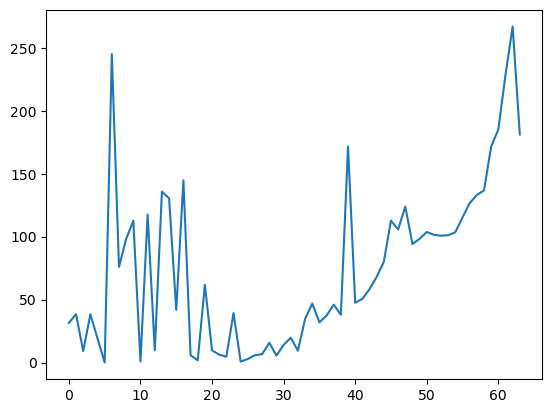

In [27]:
price_per_area['price_per_total_livable_area'].plot()

[]

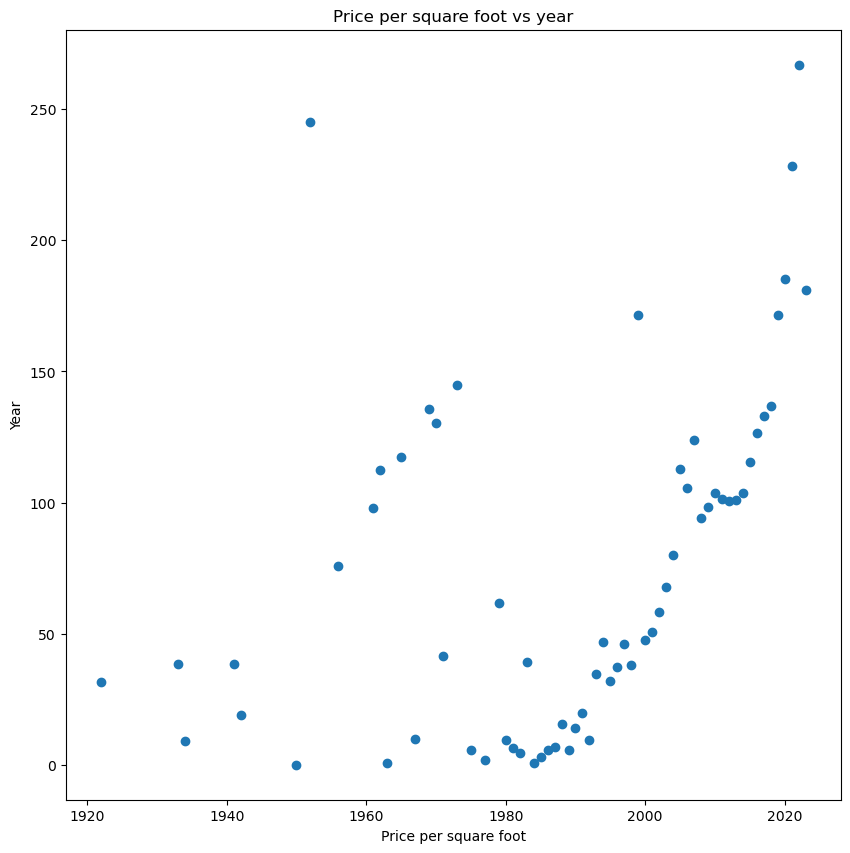

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set(title='Price per square foot vs year',
      xlabel = 'Price per square foot',
      ylabel = 'Year')
ax.scatter(price_per_area['transfer_year'], price_per_area['price_per_total_livable_area'])
ax.plot()


In [29]:
price_per_area[price_per_area['transfer_year']>1980]

,transfer_year,price_per_total_area,price_per_total_livable_area,price_per_bedroom,price_per_bathroom
21,1981.0,4.040883,6.294326,3016.666667,9.050000e+03
22,1982.0,3.710553,4.650213,1736.826667,5.210480e+03
23,1983.0,35.806441,39.298401,13875.000000,3.287500e+04
24,1984.0,0.810811,0.789474,300.000000,9.000000e+02
25,1985.0,2.897469,2.849807,1119.549167,3.702398e+03
26,1986.0,7.139681,5.840054,2200.000000,6.600000e+03
27,1987.0,7.511616,6.670139,2100.000000,6.300000e+03
28,1988.0,67.102422,15.734143,1354.166667,4.250000e+03
29,1989.0,4.903505,5.561333,3270.895833,6.375125e+03
30,1990.0,11.364668,14.054959,4183.333333,1.270000e+04


In [30]:
def fit(x, a, b, c):
    return a * np.exp(-b * (x-1984) + c)

In [31]:
after_1985 =  price_per_area[price_per_area['transfer_year']>=1985]
after_1985

,transfer_year,price_per_total_area,price_per_total_livable_area,price_per_bedroom,price_per_bathroom
25,1985.0,2.897469,2.849807,1119.549167,3.702398e+03
26,1986.0,7.139681,5.840054,2200.000000,6.600000e+03
27,1987.0,7.511616,6.670139,2100.000000,6.300000e+03
28,1988.0,67.102422,15.734143,1354.166667,4.250000e+03
29,1989.0,4.903505,5.561333,3270.895833,6.375125e+03
30,1990.0,11.364668,14.054959,4183.333333,1.270000e+04
31,1991.0,22.95431,19.733930,7002.620556,2.100786e+04
32,1992.0,11.896238,9.444685,4266.545370,9.774986e+03
33,1993.0,22.417205,34.643274,14067.388458,3.590786e+04
34,1994.0,43.909901,46.883345,20414.171501,4.369261e+04


In [32]:
popt, pcov = scipy.optimize.curve_fit(fit,  after_1985['transfer_year'], after_1985['price_per_total_livable_area'])
popt

/home/ami/projects/ml/sample_project/env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


array([ 2.76842068, -0.06004241,  2.03409831])

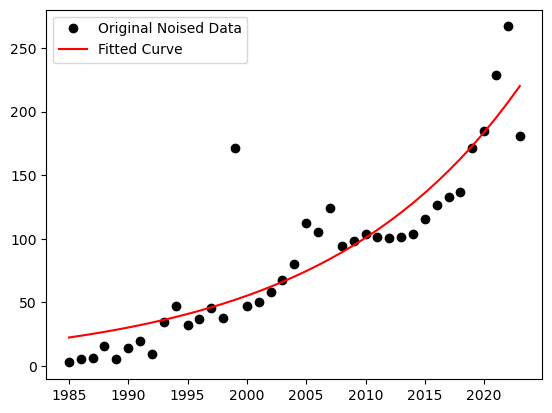

In [33]:
plt.figure()
plt.plot( after_1985['transfer_year'], after_1985['price_per_total_livable_area'], 'ko', label="Original Noised Data")
plt.plot( after_1985['transfer_year'], fit( after_1985['transfer_year'], *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

## Price per bedroom


<Axes: >

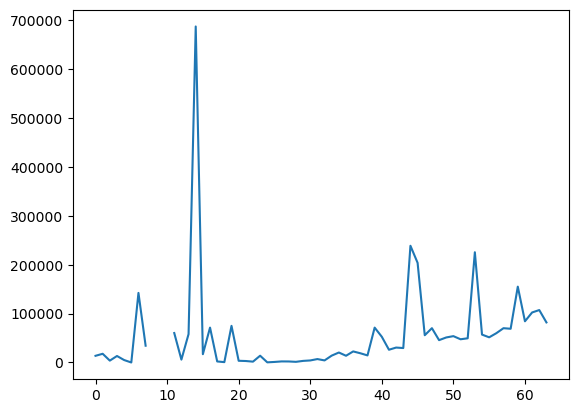

In [34]:
price_per_area['price_per_bedroom'].plot()

## Price per bathroom

<Axes: >

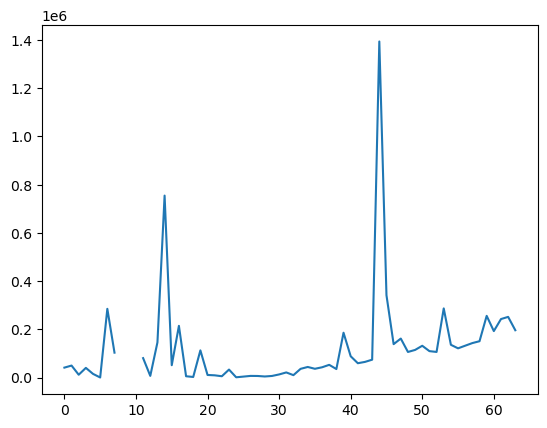

In [35]:
price_per_area['price_per_bathroom'].plot()

## See how price varies with number of bedrooms in a single year

In [36]:
price_by_bedrooms = joined_transfers[joined_transfers['transfer_year']==2022][['number_of_bedrooms','total_consideration']].groupby('number_of_bedrooms').mean()
price_by_bedrooms = price_by_bedrooms.reset_index()
price_by_bathrooms = joined_transfers[joined_transfers['transfer_year']==2022][['number_of_bathrooms','total_consideration']].groupby('number_of_bathrooms').mean()
price_by_bathrooms = price_by_bathrooms.reset_index()


<Axes: >

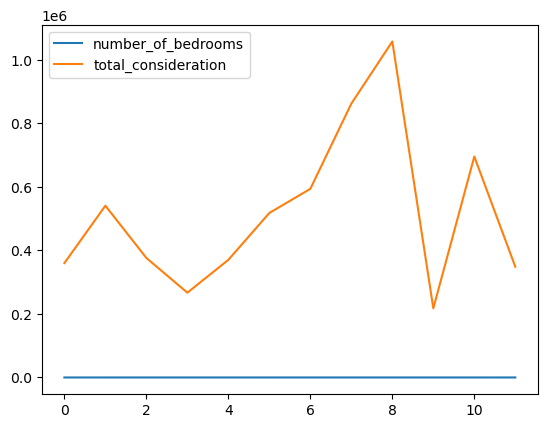

In [37]:
price_by_bedrooms.plot()

<BarContainer object of 12 artists>

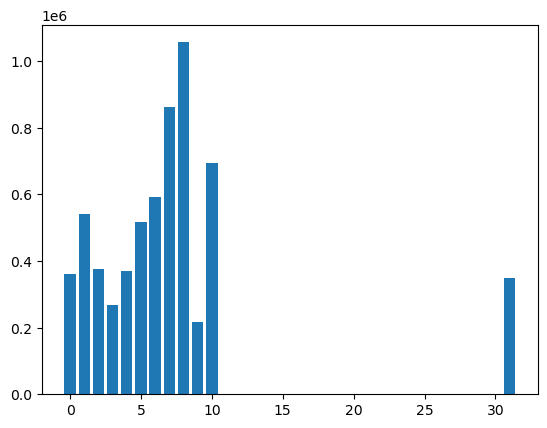

In [38]:
fig, ax = plt.subplots()
ax.bar(price_by_bedrooms['number_of_bedrooms'], price_by_bedrooms['total_consideration'])

<Axes: >

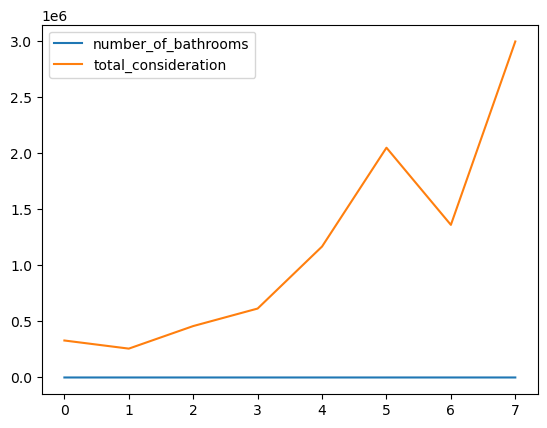

In [39]:
price_by_bathrooms.plot()

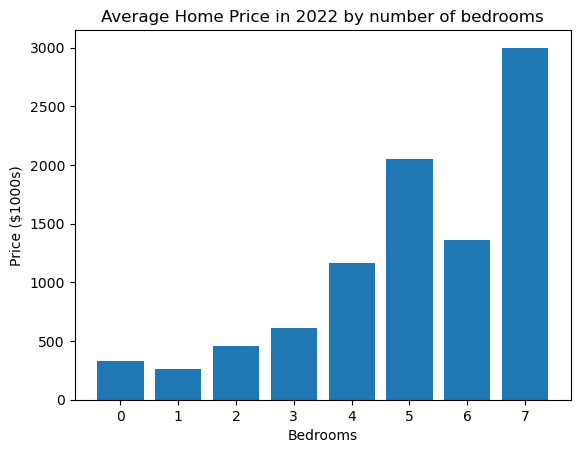

In [40]:
fig, ax = plt.subplots()
ax.set(
    title="Average Home Price in 2022 by number of bedrooms",
    ylabel="Price ($1000s)",
    xlabel="Bedrooms"
)
ax.bar(price_by_bathrooms['number_of_bathrooms'], price_by_bathrooms['total_consideration']/1000);


In [41]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

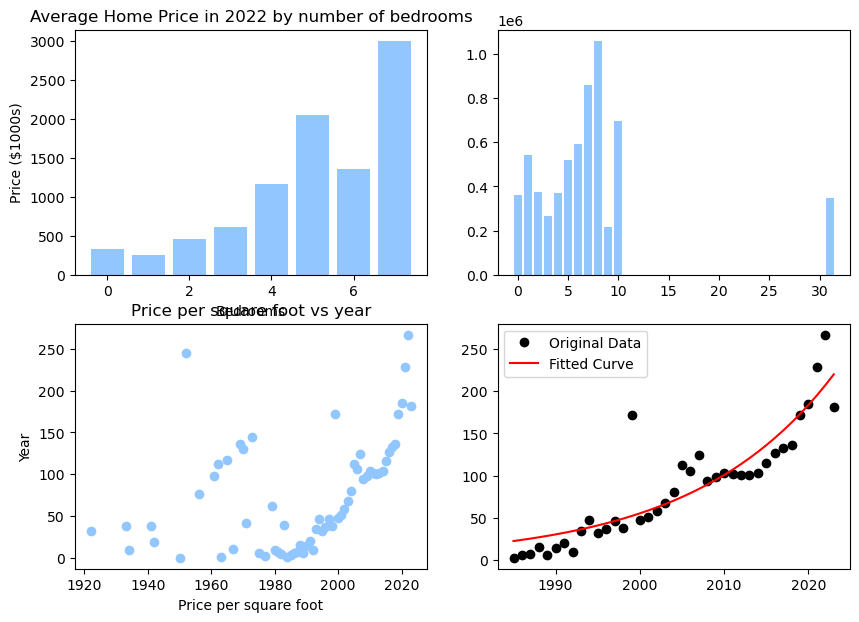

In [42]:
plt.style.use('seaborn-v0_8-pastel')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,7))

ax1.set(
    title="Average Home Price in 2022 by number of bedrooms",
    ylabel="Price ($1000s)",
    xlabel="Bedrooms"
)
ax1.bar(price_by_bathrooms['number_of_bathrooms'], price_by_bathrooms['total_consideration']/1000);

ax2.bar(price_by_bedrooms['number_of_bedrooms'], price_by_bedrooms['total_consideration'])

ax3.set(title='Price per square foot vs year',
      xlabel = 'Price per square foot',
      ylabel = 'Year')
ax3.scatter(price_per_area['transfer_year'], price_per_area['price_per_total_livable_area'])

ax4.plot( after_1985['transfer_year'], after_1985['price_per_total_livable_area'], 'ko', label="Original Data")
ax4.plot( after_1985['transfer_year'], fit( after_1985['transfer_year'], *popt), 'r-', label="Fitted Curve")
ax4.legend()


# Machine Learning


In [43]:
joined_transfers.dtypes

document_type                           object
street_address                  string[python]
total_consideration                    Float64
assessed_value                         Float64
fair_market_value                      Float64
document_date                   datetime64[ns]
address_low                     string[python]
street_name_x                   string[python]
street_suffix                   string[python]
transfer_year                          float64
basements                       string[python]
category_code                            Int32
census_tract                    string[python]
central_air                            float64
depth                                  Float32
exterior_condition              string[python]
fireplaces                               Int32
frontage                               Float32
fuel                            string[python]
garage_spaces                            Int32
garage_type                     string[python]
house_extensi

In [44]:
ml_x = joined_transfers[[
    'census_tract', 
    'transfer_year',
    'central_air',
    'depth',
    'exterior_condition',
    'fireplaces',
    'frontage',
    'garage_spaces',
    'interior_condition',
    'number_of_bathrooms',
    'number_of_bedrooms',
    'number_stories',
    'quality_grade',
    'total_area',
    'total_livable_area',
    'age',
    'zip_code'
]]
ml_y = joined_transfers[['total_consideration']]

In [45]:
ml_x.dtypes

census_tract           string[python]
transfer_year                 float64
central_air                   float64
depth                         Float32
exterior_condition     string[python]
fireplaces                      Int32
frontage                      Float32
garage_spaces                   Int32
interior_condition     string[python]
number_of_bathrooms             Int32
number_of_bedrooms              Int32
number_stories                  Int32
quality_grade                   int64
total_area                    Float32
total_livable_area            Float32
age                           float64
zip_code               string[python]
dtype: object

In [46]:
ml_x = ml_x.fillna(value={
    'census_tract': '-',
    'depth': 0,
    'frontage': 0,
    'total_area': 0,
    'total_livable_area': 0, 
    'zip_code': '00000',
})

In [47]:
categorical_features = ['census_tract', 'central_air', 'exterior_condition', 'interior_condition', 'quality_grade', 'zip_code', 'number_stories']
one_hot = OneHotEncoder(sparse_output=False)
transformer = ColumnTransformer([("one_hot", one_hot, categorical_features)], remainder="passthrough")

transformed_X = transformer.fit_transform(ml_x)

In [48]:
pd.DataFrame(transformed_X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,0.0,0,0.0,0,1,1,0.0,1208.0,5.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [49]:
np.random.seed(1205)
X_train, X_test, y_train, y_test = train_test_split(transformed_X, ml_y)

In [50]:
y_train

,total_consideration
240664,59900.0
108969,193000.0
509141,420000.0
175453,65000.0
166925,135000.0
...,...
446139,58000.0
120132,273000.0
35770,85000.0
193477,4800000.0


In [51]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train.values.ravel())
model.score(X_test, y_test)

0.9845351363424121

In [52]:
model.score(X_train, y_train)

0.986381118211062

In [53]:
dump(model, filename="real-estate-random-forest-100.joblib")

['real-estate-reandom-forest-100.joblib']

In [57]:
dump(transformer, filename="real-estate-transformer.joblib")

['real-estate-transformer.joblib']

In [55]:
ml_x.dtypes

census_tract           string[python]
transfer_year                 float64
central_air                   float64
depth                         Float32
exterior_condition     string[python]
fireplaces                      Int32
frontage                      Float32
garage_spaces                   Int32
interior_condition     string[python]
number_of_bathrooms             Int32
number_of_bedrooms              Int32
number_stories                  Int32
quality_grade                   int64
total_area                    Float32
total_livable_area            Float32
age                           float64
zip_code               string[python]
dtype: object

In [56]:
transformer.get_feature_names_out()

array(['one_hot__census_tract_-', 'one_hot__census_tract_1  ',
       'one_hot__census_tract_10 ', 'one_hot__census_tract_100',
       'one_hot__census_tract_101', 'one_hot__census_tract_102',
       'one_hot__census_tract_103', 'one_hot__census_tract_104',
       'one_hot__census_tract_105', 'one_hot__census_tract_106',
       'one_hot__census_tract_107', 'one_hot__census_tract_108',
       'one_hot__census_tract_109', 'one_hot__census_tract_11 ',
       'one_hot__census_tract_110', 'one_hot__census_tract_111',
       'one_hot__census_tract_112', 'one_hot__census_tract_113',
       'one_hot__census_tract_114', 'one_hot__census_tract_115',
       'one_hot__census_tract_117', 'one_hot__census_tract_118',
       'one_hot__census_tract_119', 'one_hot__census_tract_12 ',
       'one_hot__census_tract_120', 'one_hot__census_tract_121',
       'one_hot__census_tract_122', 'one_hot__census_tract_125',
       'one_hot__census_tract_13 ', 'one_hot__census_tract_131',
       'one_hot__census_tra